# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='Reacher-20/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        
        #self.normalizer = nn.BatchNorm1d(state_size)
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.out = nn.Linear(fc2_units, action_size)
        
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.out.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, states):
        """Build an actor (policy) network that maps states -> actions."""
        x = states
        #x = self.normalizer(x)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        return torch.tanh(self.out(x))

In [7]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, dropout=0.1, fcs1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        
        #self.normalizer = nn.BatchNorm1d(state_size)
        #self.dropout = nn.Dropout(p=dropout)
        self.seed = torch.manual_seed(seed)
        
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, states, actions):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = states
        #xs = self.normalizer(states)
        xs = F.relu(self.fcs1(xs))
        
        x = torch.cat((xs, actions), dim=1)
        x = F.relu(self.fc2(x))
        #x = self.dropout(x)
        
        return self.fc3(x)

In [8]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state


In [9]:
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 512        # minibatch size
GAMMA = 0.999           # discount factor
TAU = 1e-2              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-4        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda:0


In [10]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [11]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, device, state_size, action_size, random_seed, update_rate):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.agents_count = 20
        
        self.seed = random.seed(random_seed)
        self.update_rate = update_rate
        
        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, states, actions, rewards, next_states, dones, t):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience in replay memory
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done)

        if t % self.update_rate == 0:
            # Learn, if enough samples are available in memory
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)            
        
    def act(self, states, add_noise=True):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        self.actor_local.eval()
        
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
            
        self.actor_local.train()
        
        if add_noise:
            actions += self.noise.sample()
            
        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


In [12]:
agent = Agent(state_size=state_size, action_size=action_size, device=device, random_seed=2, update_rate=20)

In [13]:
def ddpg(n_episodes, max_t, window_size=100):
    scores_deque = deque(maxlen=window_size)
    scores_short = deque(maxlen=10)
    all_scores = []
    print('Starts training')
    for i_episode in range(1, n_episodes+1):
        agent.reset()
        
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(20)
        
        for t in range(max_t):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done

            agent.step(states, actions, rewards, next_states, dones, t)
            states = next_states
            scores += rewards

        mean_score = np.mean(scores)
        scores_deque.append(mean_score)
        scores_short.append(mean_score)
        all_scores.append(mean_score)            
                    
        print('Episode {}\tScore: {:.2f}\tAverage Score 10, 100: {:.2f} {:.2f}'.format(i_episode, mean_score, np.mean(scores_short), np.mean(scores_deque)))
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
           
        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(
                i_episode-100, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
            
    return all_scores

In [14]:
scores = ddpg(50, 2500)

Starts training
Episode 1	Score: 0.03	Average Score 10, 100: 0.03 0.03
Episode 2	Score: 0.06	Average Score 10, 100: 0.04 0.04
Episode 3	Score: 0.17	Average Score 10, 100: 0.09 0.09
Episode 4	Score: 0.16	Average Score 10, 100: 0.11 0.11
Episode 5	Score: 0.33	Average Score 10, 100: 0.15 0.15
Episode 6	Score: 0.34	Average Score 10, 100: 0.18 0.18
Episode 7	Score: 0.33	Average Score 10, 100: 0.20 0.20
Episode 8	Score: 0.55	Average Score 10, 100: 0.25 0.25
Episode 9	Score: 1.08	Average Score 10, 100: 0.34 0.34
Episode 10	Score: 0.64	Average Score 10, 100: 0.37 0.37
Episode 11	Score: 1.02	Average Score 10, 100: 0.47 0.43
Episode 12	Score: 0.96	Average Score 10, 100: 0.56 0.47
Episode 13	Score: 0.83	Average Score 10, 100: 0.62 0.50
Episode 14	Score: 0.99	Average Score 10, 100: 0.71 0.54
Episode 15	Score: 0.72	Average Score 10, 100: 0.75 0.55
Episode 16	Score: 0.83	Average Score 10, 100: 0.80 0.57
Episode 17	Score: 0.71	Average Score 10, 100: 0.83 0.57
Episode 18	Score: 0.90	Average Score 10, 

### Episode length = 1000, Actor 400/300, Critic 400/300
#### Update rate 1/4
```
  Episode 10	Score: 0.97	Average Score 10, 100: 0.50 0.50
  Episode 20	Score: 1.23	Average Score 10, 100: 0.93 0.71
  Episode 30	Score: 1.14	Average Score 10, 100: 1.43 0.95
  Episode 40	Score: 0.92	Average Score 10, 100: 0.99 0.96
  Episode 50	Score: 0.74	Average Score 10, 100: 1.07 0.98```
  
### Episode length = 2500, Actor 400/300, Critic 400/300
#### Update rate 1/20
```
  Episode 10	Score: 0.64	Average Score 10, 100: 0.37 0.37
  Episode 20	Score: 0.28	Average Score 10, 100: 0.79 0.58
  Episode 30	Score: 0.85	Average Score 10, 100: 0.87 0.68
  Episode 40	Score: 0.57	Average Score 10, 100: 0.42 0.61
  Episode 50	Score: 0.84	Average Score 10, 100: 0.71 0.63
```

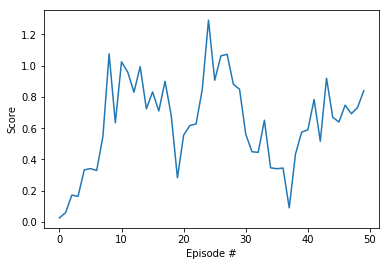

In [15]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()